In [84]:
from __future__ import print_function
from __future__ import division
import os
import pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [85]:
!jupyter nbconvert --to script preprocess.ipynb

[NbConvertApp] Converting notebook preprocess.ipynb to script
[NbConvertApp] Writing 14144 bytes to preprocess.py


In [86]:
from preprocess import read_file_list, read_en_translations

In [87]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [88]:
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

In [89]:
file_list = read_file_list()
en_words = read_en_translations(file_list["train"])

finished reading translations


In [90]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['seg', 'start', 'end'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'en_j_sim'])

In [91]:
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))

feats_dict = pickle.load(open(feats_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    

# Create parallel corpus

- Use list of files specified for training
- Create golden parallel corpus, using es transcriptions
- Create pseudotext ||| english parallel corpus
- For English, filter for content words


In [92]:
def create_parallel_corpus(segids, corpus_fname, feats_dict):
    total_errors = 0
    with open(corpus_fname, "w") as out_f:
        for seg_id in segids:
            es_words = feats_dict[seg_id]
            if not es_words:
                es_words = ['-1']
                print('Aha')
            
            if not en_words[seg_id]:
                print("hmm", seg_id)
            
            if es_words != ['-1']:
                outline = "{0:s} ||| {1:s}\n".format(" ".join(es_words), en_words[seg_id])
                out_f.write(outline)
            else:
                total_errors += 1
    print("Finished generating MT corpus")
    print("no pseudotext for for: %d utterances" % total_errors)

In [93]:
file_list["test"]

['telescope',
 'fooling',
 'strongbear',
 'stonewoman',
 'ghost',
 'owlman',
 'oldcouple']

In [94]:
create_parallel_corpus(file_list["train"], pseudo_corpus_fname, feats_dict)

hmm 038
hmm 042
hmm 067
hmm 078
hmm 079
hmm 094
hmm 102
hmm 111
hmm 138
hmm 143
hmm 153
hmm 160
hmm 171
hmm 175
Finished generating MT corpus
no pseudotext for for: 199 utterances


# Train MT model using *fast_align*

In [95]:
def train_mt(corpus_fname, probs_fname):
    FASTALIGN = config['base']['fast_align']
    subprocess.call([FASTALIGN,"-i", corpus_fname, "-v", "-N", "-p", probs_fname]) 

In [96]:
train_mt(pseudo_corpus_fname, pseudo_probs_fname)

In [97]:
def save_mt_probs(probs_fname, probs_dict_fname):
    probs_dict = {}
    with open(probs_fname, "r") as in_f:
        for i, line in enumerate(in_f):
            line_items = line.strip().split()
            es_w = line_items[0]
            if es_w not in probs_dict:
                probs_dict[es_w] = {}
            en_w = line_items[1]
            log_prob_val = float(line_items[2])
            probs_dict[es_w][en_w] = log_prob_val
    print("Finished reading mt probs file: %s" % os.path.basename(probs_fname))
    pickle.dump(probs_dict, open(probs_dict_fname, "wb"))
    print("Finished saving mt probs dictionary: %s" % os.path.basename(probs_dict_fname))
    return probs_dict
            

In [98]:
pseudo_probs_dict = save_mt_probs(pseudo_probs_fname, pseudo_probs_dict_fname)

Finished reading mt probs file: mt_probs_pseudo.txt
Finished saving mt probs dictionary: mt_probs_dict_pseudo.p


In [99]:
display(list(pseudo_probs_dict.keys())[:5])
# pseudo_probs_dict['1869']

['0', '1', '17', '23', '177']

# Make predictions

In [100]:
file_list["test"]

['telescope',
 'fooling',
 'strongbear',
 'stonewoman',
 'ghost',
 'owlman',
 'oldcouple']

In [101]:
[feats_dict[k][:5] for k in file_list["test"] if k in feats_dict]

[['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0'],
 ['130', '130', '131', '131', '132'],
 ['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0']]

In [102]:
mt_pseudo_pred_dict[1]["oldcouple"]

['snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'snow',
 'fire',
 'fire',
 'melt',
 'melt',
 'snow',
 'bones']

In [103]:
len(feats_dict)

259

In [104]:
def mt_predict(feats_dict, probs_dict, k=1):
    missing_pwords_errors = 0
    missing_mt_errors = 0
    
    pred_dict = {}
    # Sort probs dict
    probs_dict_sorted = {k: sorted(v.items(), reverse=False, key=lambda t:t[1]) for k, v in probs_dict.items()}
    
    for seg_id in feats_dict:
        # Empty list to store predicted English words
        pred_dict[seg_id] = []
        es_words = feats_dict[seg_id]
        if es_words == ['-1']:
            missing_pwords_errors += 1
        else:
            for esw in es_words:
                # Get k predictions from probs dict
                if esw in probs_dict_sorted:
                    pred_dict[seg_id].extend([w for w,p in probs_dict_sorted[esw][:k]])
                else:
                    missing_mt_errors += 1
    print("Finished making predictions")
    print("pseudoword missing for: %d utterances, and translations missing for: %d" % (missing_pwords_errors, missing_mt_errors))
    return pred_dict

In [105]:
mt_pseudo_pred_dict = {}
for k in range(1,11):
    print('\nGenerating k=%d predictions' % k)
    mt_pseudo_pred_dict[k] = mt_predict(feats_dict, pseudo_probs_dict, k=k)

pickle.dump(mt_pseudo_pred_dict, open(mt_pseudo_pred_dict_fname, "wb"))


Generating k=1 predictions
Finished making predictions
pseudoword missing for: 199 utterances, and translations missing for: 383

Generating k=2 predictions
Finished making predictions
pseudoword missing for: 199 utterances, and translations missing for: 383

Generating k=3 predictions
Finished making predictions
pseudoword missing for: 199 utterances, and translations missing for: 383

Generating k=4 predictions
Finished making predictions
pseudoword missing for: 199 utterances, and translations missing for: 383

Generating k=5 predictions
Finished making predictions
pseudoword missing for: 199 utterances, and translations missing for: 383

Generating k=6 predictions
Finished making predictions
pseudoword missing for: 199 utterances, and translations missing for: 383

Generating k=7 predictions
Finished making predictions
pseudoword missing for: 199 utterances, and translations missing for: 383

Generating k=8 predictions
Finished making predictions
pseudoword missing for: 199 uttera

# Evaluation - Precision and Recall at *k*

In [106]:
def count_match(list1, list2):
    # each list can have repeated elements. The count should account for this.
    count1 = Counter(list1)
    count2 = Counter(list2)
    common_w = set(count1.keys()) & set(count2.keys())
    #all_w = set(count1.keys()) + set(count2.keys())
    matches = sum([min(count1[w], count2[w]) for w in common_w])
    #matches = sum([max(0, count2[v]-count1[v]) for v in (count2-count1).values()])
    #matches = sum([max(0, count2[v]-count1[v]) for v in common_w])
    return matches
#     for w in all_w:
#         if w in common_w:
#     print(count1, count2)

In [107]:
def eval_mt(segids, pred_dict):
    # Get the k value from the prediction dict
    k = pred_dict.keys()
    # For every k value and for every segment, count
    #    tp - total predicted
    #    cp - correctly predicted
    #    t - total correct
    mt_eval_dict = {i: {'tp':0, 'cp':0, 't':0} for i in k}
    
    # Read segment ids to evaluate
    
    print("evaluating %d segments" % len(segids))
    missing_preds = set()
    
    for i in k:
        print("Evaluating at k=%d" % i)
        #for sid in pred_dict[i]:
        for sid in segids:
            mt_eval_dict[i][sid] = {'tp':0, 'cp':0, 't':0}
            # get predicted words
            pred_en_words = pred_dict[i][sid]
            if len(pred_en_words) == 0:
                missing_preds |= set([sid])
            # get reference english words
            ref_en_words = en_words[sid].split()
            mt_eval_dict[i][sid]['tp'] = len(pred_en_words)
            mt_eval_dict[i][sid]['cp'] = count_match(pred_en_words, ref_en_words)
            mt_eval_dict[i][sid]['t'] = len(ref_en_words)

            for count_key in ['tp', 'cp', 't']:
                mt_eval_dict[i][count_key] += mt_eval_dict[i][sid][count_key]
        # for segment ids
        # compute precision recall at every i
        mt_eval_dict[i]['precision'] = 0 if mt_eval_dict[i]['tp'] == 0 else \
                                    mt_eval_dict[i]['cp'] / mt_eval_dict[i]['tp']
        mt_eval_dict[i]['recall'] = mt_eval_dict[i]['cp'] / mt_eval_dict[i]['t']
    # for i in k predicts
    return mt_eval_dict, missing_preds

In [108]:
pseudo_mt_eval_dict = {}
pseudo_mt_eval_dict['train'], train_missing = eval_mt(file_list["train"], mt_pseudo_pred_dict)
# pseudo_mt_eval_dict['dev'], dev_missing = eval_mt(file_list["test"], mt_pseudo_pred_dict)
pickle.dump(pseudo_mt_eval_dict, open(mt_pseudo_eval_dict_fname, "wb"))

evaluating 252 segments
Evaluating at k=1
Evaluating at k=2
Evaluating at k=3
Evaluating at k=4
Evaluating at k=5
Evaluating at k=6
Evaluating at k=7
Evaluating at k=8
Evaluating at k=9
Evaluating at k=10


pseudo call train prec.: 0.4362, 0.4222, 0.4113, 0.3947, 0.3819, 0.3619, 0.3416, 0.3240, 0.3085, 0.2948
pseudo call train rec.:0.0678, 0.1256, 0.1686, 0.1983, 0.2165, 0.2231, 0.2264, 0.2298, 0.2331, 0.2364


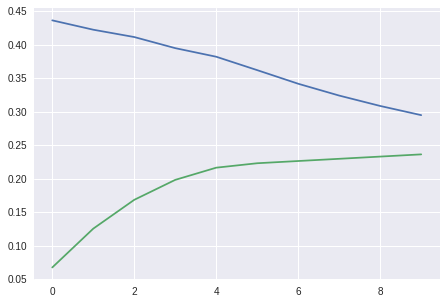

In [109]:
# plot precision, recall at i
fig = plt.figure(figsize=(16,5))
ax_1 = fig.add_subplot(121)
p_at_k = [pseudo_mt_eval_dict['train'][i]['precision'] for i in pseudo_mt_eval_dict['train']]
r_at_k = [pseudo_mt_eval_dict['train'][i]['recall'] for i in pseudo_mt_eval_dict['train']]
print("pseudo call train prec.: " + ", ".join(map(lambda v: "%.4f"%v, p_at_k)))
print("pseudo call train rec.:" + ", ".join(map(lambda v: "%.4f"%v, r_at_k)))
plt.plot(p_at_k)
plt.plot(r_at_k)
# ax_2 = fig.add_subplot(122)
# p_at_k = [pseudo_mt_eval_dict['dev'][i]['precision'] for i in pseudo_mt_eval_dict['dev']]
# r_at_k = [pseudo_mt_eval_dict['dev'][i]['recall'] for i in pseudo_mt_eval_dict['dev']]
# print("pseudo call dev prec.: " + ", ".join(map(lambda v: "%.4f"%v, p_at_k)))
# print("pseudo call dev rec.:" + ", ".join(map(lambda v: "%.4f"%v, r_at_k)))
# plt.plot(range(1,len(p_at_k)+1), p_at_k)
# plt.plot(range(1,len(p_at_k)+1), r_at_k)
# ax_2.set_xticks(range(1,len(p_at_k)+1))

In [110]:
r_at_k, range(1,len(r_at_k)+1)

([0.06776859504132231,
  0.1256198347107438,
  0.16859504132231404,
  0.19834710743801653,
  0.21652892561983472,
  0.2231404958677686,
  0.22644628099173553,
  0.22975206611570248,
  0.23305785123966943,
  0.23636363636363636],
 range(1, 11))

# Scratch

# Evaluate

In [111]:
[feats_dict[k][:5] for k in file_list["test"] if k in feats_dict]

[['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0'],
 ['130', '130', '131', '131', '132'],
 ['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0']]

In [112]:
[mt_pseudo_pred_dict[10][k] for k in file_list["test"] if k in mt_pseudo_pred_dict[10]]

[['snow',
  'ghost',
  'saw',
  'warmly',
  'lay',
  'looking',
  'around',
  'womewhere',
  'long',
  'time',
  'snow',
  'ghost',
  'saw',
  'warmly',
  'lay',
  'looking',
  'around',
  'womewhere',
  'long',
  'time',
  'snow',
  'ghost',
  'saw',
  'warmly',
  'lay',
  'looking',
  'around',
  'womewhere',
  'long',
  'time',
  'snow',
  'ghost',
  'saw',
  'warmly',
  'lay',
  'looking',
  'around',
  'womewhere',
  'long',
  'time',
  'snow',
  'ghost',
  'saw',
  'warmly',
  'lay',
  'looking',
  'around',
  'womewhere',
  'long',
  'time',
  'snow',
  'ghost',
  'saw',
  'warmly',
  'lay',
  'looking',
  'around',
  'womewhere',
  'long',
  'time',
  'snow',
  'ghost',
  'saw',
  'warmly',
  'lay',
  'looking',
  'around',
  'womewhere',
  'long',
  'time',
  'stick',
  'farther',
  'moved',
  'made',
  'fire',
  'fire',
  'stick',
  'sound',
  'suddenly',
  'heard',
  'made',
  'walked',
  'warned',
  'person',
  'wohei',
  'thought',
  'eating',
  'like',
  'going',
  'relat

In [113]:
for k, p in list(zip(range(1,len(p_at_k)+1), np.array(p_at_k) * 100)):
    print("prec @ k:{0:d} = {1:.3f}%".format(k, p))

prec @ k:1 = 43.617%
prec @ k:2 = 42.222%
prec @ k:3 = 41.129%
prec @ k:4 = 39.474%
prec @ k:5 = 38.192%
prec @ k:6 = 36.193%
prec @ k:7 = 34.165%
prec @ k:8 = 32.401%
prec @ k:9 = 30.853%
prec @ k:10 = 29.485%


In [114]:
for k, r in list(zip(range(1,len(r_at_k)+1), np.array(r_at_k) * 100)):
    print("recall @ k:{0:d} = {1:.3f}%".format(k, r))

recall @ k:1 = 6.777%
recall @ k:2 = 12.562%
recall @ k:3 = 16.860%
recall @ k:4 = 19.835%
recall @ k:5 = 21.653%
recall @ k:6 = 22.314%
recall @ k:7 = 22.645%
recall @ k:8 = 22.975%
recall @ k:9 = 23.306%
recall @ k:10 = 23.636%


# Search speech

- Take english words as a list, output speech utterances containing that English word
- Calculate precision recall for retrieved documents

In [38]:
pseudo_corpus_fname

u'../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/mt_corpus_train_pseudo.bi'

## Corpus duration

In [35]:
!wc $train_segment_list_fname
!wc $dev_segment_list_fname

wc: ../files-train.txt: No such file or directory
wc: ../files-test.txt: No such file or directory


In [40]:
print("dev")
!head $dev_segment_list_fname -n 2
!tail $dev_segment_list_fname -n 2
print("\ntrain")
!head $train_segment_list_fname -n 2
!tail $train_segment_list_fname -n 2

dev
021.001
021.002
040.089
040.090

train
041.001
041.002
120.179
120.182
